In [32]:
import nibabel as nib 
#! pip install nibabel --user
import os
import glob
import numpy as np
from nibabel.testing import data_path
import matplotlib.pyplot as plt
#import cv2
#! pip install cv2 --user
import time
from datetime import datetime
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.ndimage import zoom
import pandas as pd
import os
from skimage.io import imread
from skimage.color import gray2rgb
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torchvision as tv
from torch.utils.data import (
    Dataset,
    DataLoader,
)
import matplotlib.pyplot as plt
from torch.utils import data as DT
from skimage.transform import radon , iradon
%matplotlib inline
!pip install livelossplot --quiet
from livelossplot import PlotLosses
from sklearn.metrics import r2_score , mean_squared_error

In [33]:
###pad function to resize all images to specific size (here: 64*64*64)

def pad(img_,size_):
    dif=size_-img_.shape[0]
    if dif%2==0:
        img_=np.pad(img_,((dif//2,dif//2),(0,0),(0,0)),'edge')
    else:
        img_=np.pad(img_,(((dif-1)//2,(dif+1)//2),(0,0),(0,0)),'edge')
    dif=size_-img_.shape[1]
    if dif%2==0:
        img_=np.pad(img_,((0,0),(dif//2,dif//2),(0,0)),'edge')
    else:
        img_=np.pad(img_,((0,0),((dif-1)//2,(dif+1)//2),(0,0)),'edge')
    dif=size_-img_.shape[2]
    if dif%2==0:
        img_=np.pad(img_,((0,0),(0,0),(dif//2,dif//2)),'edge')
    else:
        img_=np.pad(img_,((0,0),(0,0),((dif-1)//2,(dif+1)//2)),'edge')
    return img_

In [34]:
# method to save the model
def save_checkpoint(state, filename="my_checkpoint_V3.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

#method to load the saved checkpoint
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [35]:
#load all PET and segmentation images(these images are already resampled and have the size of [almost] 64*64*64)
#and add padding if needed

path = 'D:\\Master_courses\\Praktikum\\challenge\\hecktor\\data\\resampled\\'

files = [f for f in glob.glob(path + "**/*_ct_gtvt.nii.gz", recursive=True)]
labels_lenght=list()
image_list=list()
label_list=list()

for idx,f in enumerate(files):
    SEG_img = nib.load(f)
    SEG_data = SEG_img.get_fdata()
    if SEG_data.shape!=(64,64,64):
        SEG_data=pad(SEG_data,64)
    label_list.append(SEG_data)
    path=f[:-15]+'_pt.nii.gz'
    im=nib.load(path)
    PET_data=im.get_fdata()
    if PET_data.shape!=(64,64,64):
        PET_data=pad(PET_data,64)
    image_list.append(PET_data)
    #print(idx)


In [36]:
len(image_list) # number of patients

200

In [37]:
print (image_list[0].shape) # shape of each image

(64, 64, 64)


In [38]:
#make label patch of 16*16*16

size = 16 # patch size
stride = 16 # patch stride

all_labels=list()
for seg_img in label_list:
    positive_cells_number=np.sum(seg_img)
    #print("positive_cells_number",positive_cells_number)
    patches = torch.from_numpy(seg_img).unfold(0, size, stride).unfold(1, size, stride).unfold(2, size, stride)
    reshaped_patches=patches.reshape(-1,size,size,size)
    labels_=(torch.sum(reshaped_patches , dim=(1,2,3)).int().numpy())/positive_cells_number
    #print ("labels_", labels_)
    all_labels.append(labels_)
all_labels=np.asarray(all_labels).reshape(-1)

In [39]:
all_labels[:64] # labels of one patient as an example

array([ 0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,
        0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,
        0.000,  0.000,  0.000,  0.000,  0.000,  0.002,  0.008,  0.000,
        0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,
        0.000,  0.000,  0.001,  0.000,  0.000,  0.112,  0.691,  0.035,
        0.000,  0.017,  0.105,  0.001,  0.000,  0.000,  0.000,  0.000,
        0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.026,  0.000,
        0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000])

In [40]:
#make image patch of 16*16*16

all_PET_patches=list()
for PET_img in image_list:
    patches = torch.from_numpy(PET_img).unfold(0, size, stride).unfold(1, size, stride).unfold(2, size, stride)
    reshaped_patches=patches.reshape(-1,size,size,size).numpy()
    all_PET_patches.append(reshaped_patches)
all_PET_patches=np.asarray(all_PET_patches).reshape(-1,size,size,size)

In [41]:
print (all_PET_patches.shape) #number of patches * pactch dim1 * patch dim2 * patch dim3
patch_mean=np.mean(all_PET_patches , axis=0)
patch_std=np.std(all_PET_patches , axis=0)

(12800, 16, 16, 16)


In [42]:
class HN_Dataset(Dataset):
    def __init__(self, transform=tv.transforms.Compose(tv.transforms.ToTensor())):
        self.labels = all_labels
        self.images=all_PET_patches
        self.transform = transform
        self.mode='None'
    def __len__(self):
        return len(all_labels)

    def __getitem__(self, idx):

        label= torch.from_numpy(np.asarray(self.labels[idx]))
        
        if self.transform is not None:
            PET_data = self.transform(self.images[idx])
        return (PET_data, label)

In [43]:
split_threshold=10000  # to split test and train set (10000 out of 12800 for train set)
batch_size = 64

# Load Data

idx = list(range(len(all_labels)))

dataset = HN_Dataset( transform=tv.transforms.ToTensor())
train_set = DT.Subset(dataset, idx[:split_threshold])
test_set = DT.Subset(dataset, idx[split_threshold:])

#train_set, test_set = torch.utils.data.random_split(dataset, [10000, 2800])

train_set.transform= tv.transforms.Compose([#tv.transforms.RandomHorizontalFlip(),
                                            #tv.transforms.RandomVerticalFlip(),
                                            tv.transforms.ToTensor(),
                                            tv.transforms.Normalize(patch_mean, patch_std)
                                           ])

#tv.transforms.RandomRotation(180),

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


In [44]:
class CNN_conv2d(nn.Module):
    def __init__(self, in_channels=16, num_classes=1):
        super(CNN_conv2d, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(5,5),
            stride=(2, 2),
            padding=(1, 1),
        )
        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=16,
            kernel_size=(3 ,3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv3 = nn.Conv2d(
            in_channels=16,
            out_channels=8,
            kernel_size=(3 ,3),
            stride=(1, 1),
            #padding=(1, 1),
        )

        
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        self.fc1 = nn.Linear(16 * 1 * 1, num_classes)
        self.fc2 = nn.Linear(8, num_classes)
        
        self.sig=nn.Sigmoid()
        
        self.BatchNorm64=nn.BatchNorm2d(64)
        self.BatchNorm32=nn.BatchNorm2d(32)
        self.BatchNorm8=nn.BatchNorm2d(8)
        self.BatchNorm128=nn.BatchNorm2d(128)
        self.BatchNorm16=nn.BatchNorm2d(16)
        self.layernorm1=nn.LayerNorm((64, 16, 16))
        self.layernorm2=nn.LayerNorm((32, 8, 8))
        self.layernorm3=nn.LayerNorm((16, 4, 4))
        
        self.dropout= nn.Dropout(p=0.25)
        
        self.initialize_weights()

        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        #x= self.layernorm1(x)
        x = self.BatchNorm32(x)
        x = self.pool(x)
        x = F.leaky_relu(self.conv2(x))
        #x = self.BatchNorm16(x)
        #x= self.layernorm2(x)
        x = self.pool(x)
        x=self.dropout(x)
        #x = F.leaky_relu(self.conv3(x))
        #x = self.BatchNorm8(x)
        #x= self.layernorm3(x)
        #x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        #x = self.fc2(x)
        x=self.sig(x)
        return x

    

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)


In [45]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters

num_epochs = 80
learning_rate = 1e-3
batch_size = 64

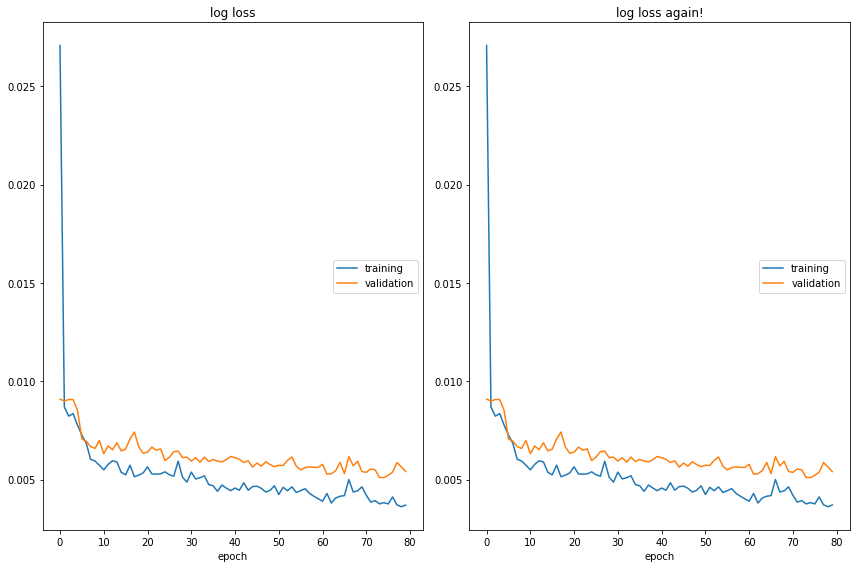

log loss
	training         	 (min:    0.004, max:    0.027, cur:    0.004)
	validation       	 (min:    0.005, max:    0.009, cur:    0.005)
log loss again!
	training         	 (min:    0.004, max:    0.027, cur:    0.004)
	validation       	 (min:    0.005, max:    0.009, cur:    0.005)


In [46]:
#device=torch.device("cpu")
# Initialize network
model = CNN_conv2d().to(device)
liveloss = PlotLosses()

# Loss and optimizer
criterion=nn.MSELoss()
#criterion=my_loss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

load_module=False

ref=1

dataloaders = {
    "train": train_loader,
    "validation": test_loader
}

# Train Network
for epoch in range(num_epochs):
    logs = {}
    for phase in ['train', 'validation']:

        if phase == 'train':
            model.train()
        else:
            model.eval()

            
        running_loss = 0.0
        running_corrects = 0.0

        for inputs, labels in dataloaders[phase]:
            # Get data to cuda if possible
            inputs = inputs.to(device=device)
            labels = labels.to(device=device)

            # forward
            inputs=inputs.float()
            scores = model(inputs)
            labels=labels.float()
            scores=scores.view(-1)

            loss = criterion(scores, labels)
            #loss2 = criterion(scores, labels)            
            # backward
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                # gradient descent or adam step
                optimizer.step()
            preds=torch.round(scores)
    
            running_loss += loss.detach() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
        
        #if phase == 'validation':
        #    this_loss=(running_loss / len(dataloaders[phase].dataset)).item()
        #    if this_loss<ref:
        #        checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
        #        # save checkpoint
        #        save_checkpoint(checkpoint)
        #        ref=this_loss
        #        print ("epoch {}:loss{}".format(epoch,ref)) 
        
        prefix = ''
        if phase == 'validation':
            prefix = 'val_'

        logs[prefix + 'log loss'] = epoch_loss.item()
        logs[prefix + 'log loss again!'] = epoch_loss.item()
        #logs[prefix + 'accuracy'] = epoch_acc.item()
        
    liveloss.update(logs)
    liveloss.send()



In [47]:
#load_checkpoint(torch.load("my_checkpoint_V3.pth.tar"), model, optimizer)


In [48]:
#MAIN
#device = torch.device("cpu")
num_epochs = 81
# Initialize network

model = CNN_conv2d().to(device)

# Loss and optimizer
criterion=nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
load_module=False
print("Current Time =", datetime.now().strftime("%H:%M:%S")) 
# Train Network
for epoch in range(num_epochs):
    now = datetime.now()
    if load_module:
        # load checkpoint
        load_checkpoint(torch.load("my_checkpoint_V3_percent.pth.tar"), model, optimizer)
        load_module=False
    losses = []
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        data=data.float()
        scores = model(data)
        targets=targets.float()
        scores=scores.view(-1)

        loss = criterion(scores, targets)
        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
    if (epoch % 20==0):
        print(f"Cost at epoch {epoch} is {np.sum(losses)/len(losses)}")
        print("Current Time =", now.strftime("%H:%M:%S")) 
        checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
        # save checkpoint
        save_checkpoint(checkpoint)
        


Current Time = 09:35:15
Cost at epoch 0 is 0.011962806518266724
Current Time = 09:35:15
=> Saving checkpoint
Cost at epoch 20 is 0.0046896642078229364
Current Time = 09:36:06
=> Saving checkpoint
Cost at epoch 40 is 0.00463077320510953
Current Time = 09:36:57
=> Saving checkpoint
Cost at epoch 60 is 0.0037829893836786887
Current Time = 09:37:48
=> Saving checkpoint
Cost at epoch 80 is 0.0034066503828925868
Current Time = 09:38:40
=> Saving checkpoint


In [49]:
# Check accuracy on training to see how good our model is

def check_accuracy(loader, model, test_set):
    total_mse=0
    model.eval()
    idx=0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x=x.float()
            scores = model(x)
            predictions=scores
            
            MSE=mean_squared_error(np.ravel(predictions.cpu().numpy()),np.ravel(y.cpu().numpy()))
            total_mse=total_mse+MSE
            idx=idx+1
            if test_set:
                
                np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
                print ("labels:       ",np.ravel(y.cpu().numpy()))
                print ("predictions:  ",np.ravel((predictions.cpu().numpy())))
                print ("mean_squared_error",MSE)
                #print ("r2_score",r2_score(np.ravel(predictions.cpu().numpy()),np.ravel(y.cpu().numpy())))

    print ("total_mse",total_mse/idx)
        
    model.train()


In [50]:
print("Checking accuracy on Training Set")
check_accuracy(train_loader, model ,test_set=False)

print("Checking accuracy on Test Set")
check_accuracy(test_loader, model, test_set=False)

Checking accuracy on Training Set
total_mse 0.003091515539933448
Checking accuracy on Test Set
total_mse 0.005677415515485041


In [51]:
print("Checking accuracy on Test Set")
check_accuracy(test_loader, model, test_set=True)

Checking accuracy on Test Set
labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.034  0.455  0.014  0.000  0.117  0.297  0.005  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.040  0.000
  0.000  0.000  0.038  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.020
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.028  0.002
  0.000  0.000  0.707  0.010  0.000  0.033  0.383  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.001  0.000  0.000
  0.000  0.043  0.013  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
mean_squared_error 0.0013125

predictions:   [ 0.000  0.000  0.021  0.001  0.000  0.000  0.006  0.000  0.000  0.002
  0.000  0.012  0.000  0.000  0.000  0.000  0.000  0.000  0.001  0.000
  0.000  0.000  0.007  0.000  0.000  0.000  0.000  0.001  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.001
  0.000  0.000  0.000  0.000]
mean_squared_error 0.015427564363342115
labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.028  0.003  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.048  0.069
  0.000  0.000  0.570  0.212  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.008  0.010  0.000  0.000  0.028  0.024
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.299  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.627  0.073  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.002  0.000  0.000  0.000
  0.001  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.001  0.000  0.001  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
mean_squared_error 0.007628818631502471
labels:        [ 0

In [52]:
#method to add radon noise to images

PEAK=100
def make_noisy_image(image):
    img=np.zeros(image.shape)
    for idx, _2d_img in enumerate(image):  
        
        theta = np.linspace(0., 180., max(_2d_img.shape), endpoint=False)
        sinogram = radon(_2d_img, theta=theta, circle=False)
        sinogram=np.clip(sinogram, 0,None)
        noisy = np.random.poisson(sinogram * PEAK)/PEAK  
        img[idx] = iradon(noisy, theta=theta, circle=False)
    return img

In [53]:
#again load all images, add padinf if needed, then add radon noise

path = 'D:\\Master_courses\\Praktikum\\challenge\\hecktor\\data\\resampled\\'
#_ct_gtvt.nii.gz
#_pt.nii.gz
files = [f for f in glob.glob(path + "**/*_pt.nii.gz", recursive=True)]
noisy_image_list=list()

for idx,f in enumerate(files):
    
    im=nib.load(f)
    PET_data=im.get_fdata()   
    if PET_data.shape!=(64,64,64):
        PET_data=pad(PET_data,64)
    PET_data=make_noisy_image(PET_data)   
    noisy_image_list.append(PET_data)


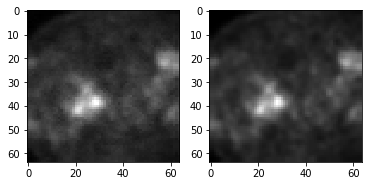

In [54]:
fig = plt.figure()
a = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(noisy_image_list[0][:,:,50],cmap='gray')
a = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(image_list[0][:,:,50],cmap='gray')


In [55]:
#make image patches of size 16*16*16

all_noisy_PET_patches=list()
for PET_img in noisy_image_list:
    patches = torch.from_numpy(PET_img).unfold(0, size, stride).unfold(1, size, stride).unfold(2, size, stride)
    reshaped_patches=patches.reshape(-1,size,size,size).numpy()
    all_noisy_PET_patches.append(reshaped_patches)
all_noisy_PET_patches=np.asarray(all_noisy_PET_patches).reshape(-1,size,size,size)

In [56]:
#class dataset of noisy images
class noisy_HN_Dataset(Dataset):
    def __init__(self, transform=tv.transforms.Compose(tv.transforms.ToTensor())):
        self.labels = all_labels
        self.images=all_noisy_PET_patches
        self.transform = transform
        self.mode='None'
    def __len__(self):
        return len(all_labels)

    def __getitem__(self, idx):

        label= torch.from_numpy(np.asarray(self.labels[idx]))        
        if self.transform is not None:
            PET_data = self.transform(self.images[idx])
        return (PET_data, label)

In [57]:
#making train and test set for noisy image

split_threshold=10000
idx = list(range(len(all_labels)))

noisy_dataset = noisy_HN_Dataset( transform=tv.transforms.ToTensor())

################################ IMPOSTANT ############################################
#As I don't use "randome split" for splitting test and train set, we can easily compare results of this test set with previous one(no noise test set)
noisy_train_set = DT.Subset(noisy_dataset, idx[:split_threshold])
noisy_test_set = DT.Subset(noisy_dataset, idx[split_threshold:])

#noisy_train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
noisy_test_loader = DataLoader(noisy_test_set, batch_size=batch_size, shuffle=False)

In [58]:
print("Checking accuracy on Test Set")
check_accuracy(noisy_test_loader, model, test_set=False)

Checking accuracy on Test Set
total_mse 0.00573813788272732


In [59]:
print("Checking accuracy on Test Set")
check_accuracy(noisy_test_loader, model, test_set=True)

Checking accuracy on Test Set
labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.034  0.455  0.014  0.000  0.117  0.297  0.005  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.040  0.000
  0.000  0.000  0.038  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.021
  0.001  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.029  0.000
  0.000  0.000  0.712  0.003  0.000  0.034  0.383  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.001  0.000  0.000
  0.000  0.035  0.013  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
mean_squared_error 0.0013455

  0.000  0.000  0.000  0.000]
mean_squared_error 0.0003824535954223411
labels:        [ 0.000  0.000  0.000  0.000  0.000  0.025  0.178  0.000  0.000  0.171
  0.627  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.011  0.000  0.000  0.055  0.040  0.000  0.000  0.000
  0.012  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.002  0.000
  0.000  0.002  0.000  0.000  0.002  0.001  0.120  0.001  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0

labels:        [ 0.000  0.000  0.013  0.010  0.000  0.000  0.304  0.432  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.089  0.152  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.012  0.000  0.000  0.001  0.024  0.084  0.000  0.000
  0.000  0.010  0.000  0.000  0.000  0.000  0.000  0.000  0.014  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.001  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
mean_squared_error 0.003611046022441941
labels:        [ 0

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.011  0.000
  0.000  0.044  0.621  0.015  0.000  0.011  0.130  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.094  0.040  0.000
  0.000  0.010  0.025  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.001  0.000  0.000  0.000  0.002  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.014  0.000
  0.000  0.003  0.579  0.000  0.000  0.003  0.064  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
mean_squared_error 0.0003987119151916869
total_mse 0.00573813788272732
